In [32]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext tensorboard

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import os
from datetime import datetime

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Sequential Data

Recurrent Nerual Networks

Variations

Language modelling here ! 



# Sequential Data


# Recurrent neural network

A recurrent neural network (RNN) is a class of artificial neural networks where connections between nodes form a directed graph along a sequence (often temporal). This allows it to exhibit temporal dynamic behavior. Derived from feedforward neural networks, RNNs can use their internal state (memory) to process variable length sequences of inputs. This makes them applicable to tasks such as unsegmented, connected handwriting recognition, speech recognition, language modelling and time series forecasting.

The term *recurrent neural network* is used indiscriminately to refer to two broad classes of networks with a similar general structure, where one is finite impulse (whose impulse response (or response to any finite length input) is of finite duration, because it settles to zero in finite time) and the other is infinite impulse (whose impulse response does not become exactly zero past a certain point, but continues indefinitely). Both classes of networks exhibit temporal dynamic behavior. A finite impulse recurrent network is a directed acyclic graph that can be unrolled and replaced with a strictly feedforward neural network, while an infinite impulse recurrent network is a directed cyclic graph that can not be unrolled.

Both finite impulse and infinite impulse recurrent networks can have additional stored states, and the storage can be under direct control by the neural network. The storage can also be replaced by another network or graph, if that incorporates time delays or has feedback loops. Such controlled states are referred to as gated state or gated memory, and are part of long short-term memory networks (LSTMs) and gated recurrent units. This is also called Feedback Neural Network. In theory RNNs can make use of information in arbitrarily long sequences (which is useful for language models).

## Vanilla RNNs

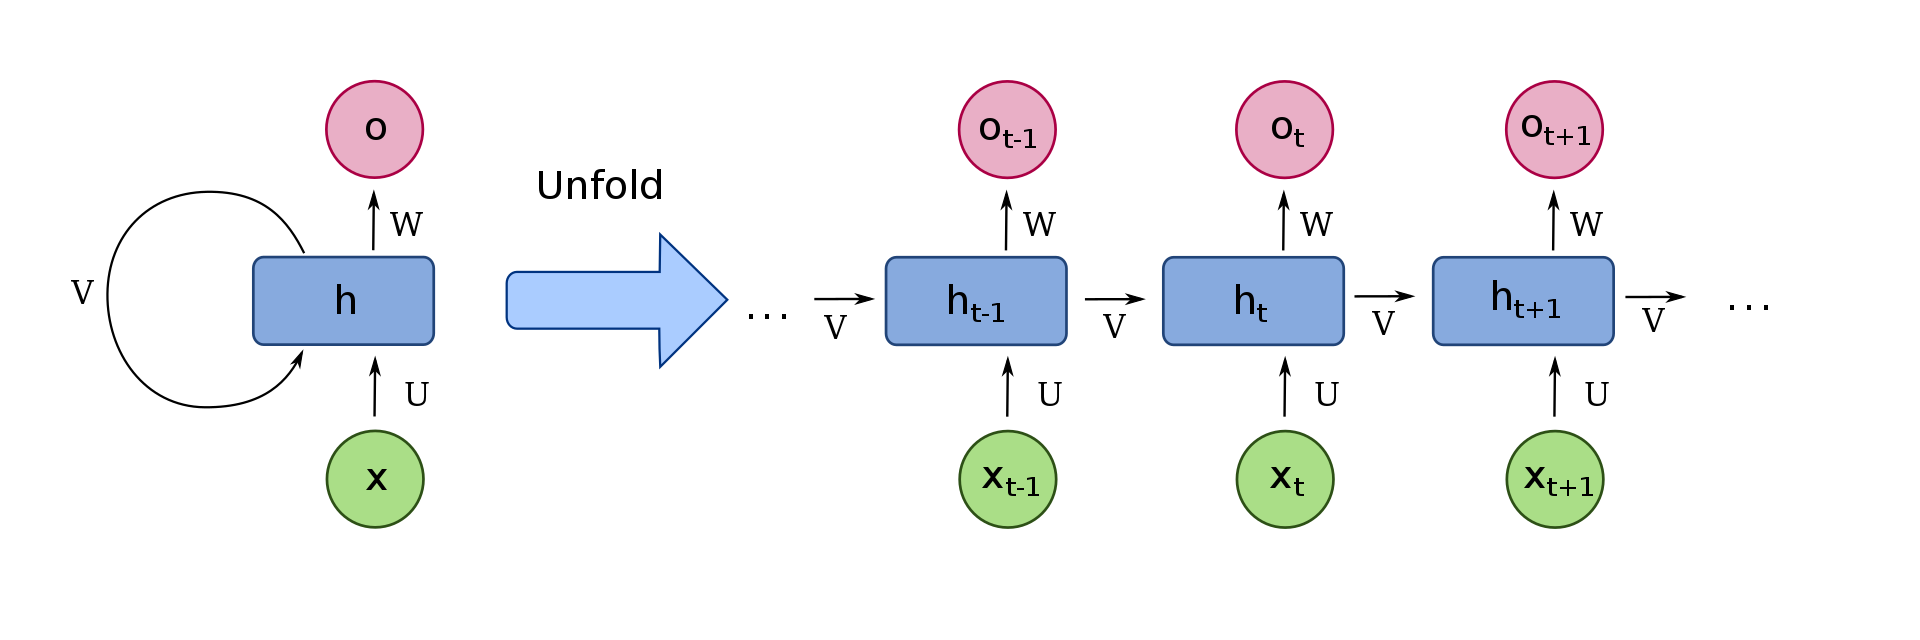
> A recurrent neural network (RNN) and the unfolding in time of the computation involved in its forward computation.

The above image shows a RNN being unrolled (also known as unfolding) into a full network. 
Here unrolling is equiavelent to writing out in full the network for a complete sequence. For instance if we have a sequence of $4$ samples, the network would be unrolled into a $4$-layer dense fully connected neural network, one layer for each sample of interest. This can be expressed as:

$$h_t=\sigma(U x_t + V h_{t-1})$$

Where:
* $x_t$ is the input at time step $t$. For example, $x_1$ could be a sample corresponding to the second sample of the sequence.
* $h_t$ is the hidden state at time step $t$. It is the “memory” of the network. $h_t$ is calculated based on the previous hidden state and the input at the current step: $h_t=\sigma(U x_t + V h_{t-1})$. $h_{-1}$, which is required to calculate the first hidden state, is typically initialized to all zeroes.
* $\sigma$ activation function : usually a non-linearity such as tanh or ReLU.
* $o_t$ is the output at step $t$, here $o_t=h_t$

We can think of the hidden state $h_t$ as the memory of the network, as it captures information about what happened in all the previous time steps. The output at step $o_t$ is calculated solely based on the memory at time $t$. Here a RNN shares the same parameters $(U, V)$ across all steps, this is as we are performing the same operations almost in a *for* loop, just with different inputs. The above diagram shows the two representations for the same RNN *rolled*, we have out output of $o_t$ or *un-rolled* with an output of the sequence of the outputs of the hidden states. Depending on our architecture we may need one form or the other. Similarly, we may not need inputs at each time step. In practice however, it is difficult to access information from many steps
back due to problems like vanishing and exploding gradients, which we discuss shortly.



### RNN from scratch

Lets implement the above in numpy, note that this is a naive implementation, and is only useful to aid understanding


In [33]:
input_features = 1
output_features = 2

U = np.random.random((output_features, input_features))
V = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

inputs = [[1], [2], [3], [4]] # Dim : (sequence_length, input_features)
h_t  = np.zeros((output_features,))

outputs = [] # Dim : (sequence_length, output_features)
for x_t in inputs:
    h_t = np.tanh(np.dot(U, x_t) + np.dot(V, h_t) + b)
    outputs.append(h_t)

print('Output Sequence\n', np.array(outputs)) 

Output Sequence
 [[0.75582339 0.92270988]
 [0.98644211 0.99692686]
 [0.99682389 0.99944992]
 [0.99895519 0.99986996]]


We can see that a RNN is a simple *for* loop the reuses the previous output from the hidden layer during the loop.

# RNN in Keras

A simple RNN (such as the above) is the `tf.keras.layers.SimpleRNN` layer in Keras, which is a fully-connected RNN where the output is to be fed back to input. It takes the regular Keras layer arguments, with a few specific following keyword arguments:
* `units`: Positive integer, dimensionality of the output space.
* `activation`: Activation function to use. Default: hyperbolic tangent (tanh). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
* `use_bias`: Boolean, (default True), whether the layer uses a bias vector.
* `kernel_initializer`: Initializer for the kernel weights matrix, used for the linear transformation of the inputs. Default: glorot_uniform.
* `recurrent_initializer`: Initializer for the recurrent_kernel weights matrix, used for the linear transformation of the recurrent state. Default: orthogonal.
* `bias_initializer`: Initializer for the bias vector. Default: zeros.
* `kernel_regularizer`: Regularizer function applied to the kernel weights matrix. Default: None.
* `recurrent_regularizer`: Regularizer function applied to the recurrent_kernel weights matrix. Default: None.
* `bias_regularizer`: Regularizer function applied to the bias vector. Default: None.
* `activity_regularizer`: Regularizer function applied to the output of the layer (its "activation"). Default: None.
* `kernel_constraint`: Constraint function applied to the kernel weights matrix. Default: None.
* `recurrent_constraint`: Constraint function applied to the recurrent_kernel weights matrix. Default: None.
* `bias_constraint`: Constraint function applied to the bias vector. Default: None.
* `dropout`: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs. Default: 0.
* `recurrent_dropout`: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state. Default: 0.
* `return_sequences`: Boolean. Whether to return the last output in the output sequence, or the full sequence. Default: False. (This is the same to *unrolling* the outputs, as seen above)
* `return_state`: Boolean. Whether to return the last state in addition to the output. Default: False
* `go_backwards`: Boolean (default False). If True, process the input sequence backwards and return the reversed sequence.
* `stateful`: Boolean (default False). If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.
* `unroll`: Boolean (default False). If True, the network will be unrolled, else a symbolic loop will be used. Unrolling can speed-up a RNN, although it tends to be more memory-intensive. Unrolling is only suitable for short sequences.